In [1]:
"""
pytorch 및 필요 라이브러리 호출
"""

import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import math
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# 데이터 정규화를 위한 함수 호출 (Normalized)
transform = transforms.ToTensor()
# torch library 에서 CIFAR10 데이터셋 다운로드 및 데이터 정규화
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# GPU에 데이터 적재를 하기 위한 전처리를 수행하는 cpu 개수
NW = 10
# dataset 에 추가할 noise 강도
noise_factor = 0.1
# Batch size
batch_size = 32

# dataset 을 pytorch가 처리할수있는 변수로 포팅함
# Next function 으로 매 iteration 마다 batch size 에 해당하는 이미지 도출, 이미 전처리를 위한 cpu 의 개수를 NW 로 할당해줌
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=NW)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=NW)

# GPU 사용 여부
print(f"GPU : {torch.cuda.is_available()}")

GPU : True


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt 를 사용하여 이미지 출력, transpose 함수로 변수의 차원 재정렬 
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

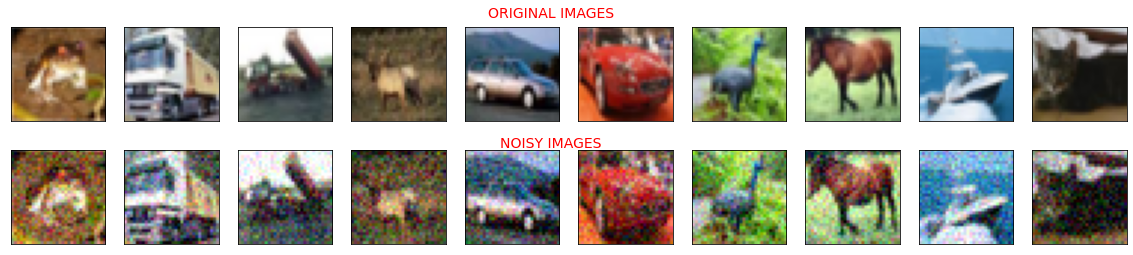

In [5]:
# train loader를 iteration 을 진행시켜 이미지를 뽑아냄
dataiter = iter(train_loader)
images, labels = dataiter.next()
# next 함수로 첫번째 batch 에 해당하는 이미지와 라벨을 추출

#이미지에 noise 를 더해줌 noise_factor(강도)*랜덤 노이즈
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
#Clip 함수를 통해 최대 최소값음 0,1 로 변환
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
# 이미지들를 넘파이 어레이로 변환함
images = images.numpy() 
noisy_imgs=noisy_imgs.numpy()

#이미지를 출력하기 위한 함수
def showOrigDec(orig, noise, num=10):
    """
    num 개의 이미지를 출력함
    이미지의 크기는 20,4 사이즈임
    subplot을 열어 original 이미지와 noise가 더해진 이미지를 동시에 시각화함
    
    figtext 함수로 이미지에 대한 설명을 추가함 (Original Image), (Noisy image)
    """
    plt.figure(figsize=(20, 4))

    for i in range(num):
        # display original
        ax = plt.subplot(2, num, i+1)
        imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, num, i +1 + num)
        imshow(noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.5, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.subplots_adjust(hspace = 0.3 )
    plt.show()
showOrigDec(images,noisy_imgs)

### Dataset 에 대한 설명

CIFAR-10은 32x32픽셀의 60000개 컬러이미지가 포함되어있으며, 각 이미지는 10개의 클래스로 라벨링이 되어있습니다.
MNIST 와 함께 가장 널리 사용되는 dataset 중 하나임
Class로 트럭 배 말 개구리 개 사슴 고양이 새 자동차 비행기가 있음
훈련으로 50000, 테스트로 10000개를 사용함

In [ ]:
# NN 네트워크를 build 하였음
# 레이어의 개수는 17개, feature 의 개수는 64개임
# 2D CNN을 사용하였음, Kernel size(filter size)는 3*3 이고 stride(이동값)은 1임, padding으로 이미지의 크기를 유지함
# 첫레이어는 BatchNormalization 을 사용하지 않았고 15개의 Layer는 Batch normalization 을 사용하였음 16번째 레이어 까지는 ReLu를 activation function 으로 사용함
# 마지막 CNN 레이어는 Activation function 을 사용하지 않음.

#initialize_weights 함수를 define 해서 초기값을 초기화하였음.
# kaiming_normal을 통해 CNN 을 초기화하였고 Batchnorm은 1과 0으로 초기화함.

# original 이미지에 CNN 처리한 이미지를 빼서 출력값으로 정함
class DnCNN(nn.Module):
    def __init__(self, num_layers=17, num_features=64):
        super(DnCNN, self).__init__()
        layers = [nn.Sequential(nn.Conv2d(3, num_features, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(inplace=True))]
        for i in range(num_layers - 2):
            layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(num_features),
                                        nn.ReLU(inplace=True)))
        layers.append(nn.Conv2d(num_features, 3, kernel_size=3, padding=1))
        self.layers = nn.Sequential(*layers)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, inputs):
        y = inputs
        residual = self.layers(y)
        return y - residual

# DnCNN 으로 define 하고, GPU에 모델을 올림
model = DnCNN()
model.cuda()
print(model)


# 손실함수와 옵티마이저를 정의함 손실함수는 Mean Squared Error, 옵티마이저는 Adam 을 사용함. Learning rate은 0.001임
Lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 훈련을 진행할 iteration 횟수를 지정
n_epochs = 5


for epoch in range(1, n_epochs+1):
    # loss를 모니터링 하기 위한 변수 초기화
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        #Train loader로 부터 이미지를 얻어옴
        images, _ = data
        
        ## 이전에 정의한 noise factor 로 이미지에 노이즈를 추가함
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # 노이즈를 추가하여 min,max 값이 달라졌으므로 clip 함수를 통해 min max를 0과 1로 맞춰줌
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # 옵티마이저의 값을 0으로 초기화해줌
        optimizer.zero_grad()
        # 노이즈를 추가한 이미지를 gpu에 올리고 Model에 넣어서 Output을 얻음
        outputs = model(noisy_imgs.cuda())
        # 손실함수를 계산함, 모델에 넣은 Noise 이미지와 원래 이미지간의 MSE 를 계산함. 네트워크가 노이즈를 완벽하게 제거했으면 두 이미지는 완벽하게 같아야함
        loss = Lossfunc(outputs, images.cuda())
        # Loss를 기반으로 Backpropagation 을 준비함
        loss.backward()
        # Adam 옵티마이저로 모든 weight 를 변경
        optimizer.step()
        # 출력을 위한 loss 변수 업데이트
        train_loss += loss.item()*images.size(0)
            
    # loss 출력
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

DnCNN(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
# 훈련된 모델을 denoise_DnCNN.pt 파일로 저장
torch.save(model,"denoise_DnCNN.pt")

# 네트워크의 성능을 검증하기 위해서 test_loader 로 부터 이미지를 뽑아냄
dataiter = iter(test_loader)
images, labels = dataiter.next()

# test 세트에 노이즈를 추가함 방식은 train에서 했던것과 동일함
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# 네트워크로 노이즈가 제거된 이미지 출력
output = model(noisy_imgs.cuda())



# 차원변환을 통해 plt가 유저에게 보여줄 수 있는 형태로 변환
output = output.view(batch_size, 3, 32, 32)
# gpu에 올려져 있는 데이터를 cpu로 옮겨옴
output = output.detach().cpu()

# trainset 을 visualize 한것과 동일한 방식으로 이미지를 보여줌
# 단, 이번에는 denosie 된 이미지도 같이 출력함
def showOrigNoiseOut(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        imshow(noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        imshow(denoise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="b")
    plt.figtext(0.5,0.65, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="b")
    plt.figtext(0.5,0.35, " DENOISED RECONSTRUCTED IMAGES", ha="center", va="top", fontsize=14, color="b")
    plt.subplots_adjust(hspace = 0.5 )
    plt.show()
    
showOrigNoiseOut(images, noisy_imgs, output)